In [27]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
old_root = Path('/ihme/covid-19/seir-pipeline-outputs/regression/2020_07_08.integration_test_2')
new_root = Path('/ihme/covid-19/seir-regression/2020_07_08.03')
old_betas_path = old_root / 'betas'
new_betas_path = new_root / 'beta'
old_params_path = old_root / 'parameters'
new_params_path = new_root / 'parameters'
old_coef_path = old_root / 'coefficients'
new_coef_path = new_root / 'coefficients'

In [4]:
def load_loc_draw_files(root: Path) -> pd.DataFrame:
    data = []
    for loc_dir in root.iterdir():
        data.append(load_draw_files(loc_dir))
    return pd.concat(data)

def load_draw_files(root: Path):
    data = []
    for draw_file in root.iterdir():
        df = pd.read_csv(draw_file)
        df['draw'] = int(draw_file.stem.split('_')[-1])
        data.append(df)
    return pd.concat(data)

In [22]:
%%time
old_betas = load_loc_draw_files(old_betas_path).drop(columns='location_id').rename(columns={'loc_id': 'location_id', 'testing_reference': 'testing'}).sort_values(['location_id', 'draw', 'date']).reset_index(drop=True).set_index(['location_id', 'date'])
new_betas = load_draw_files(new_betas_path).sort_values(['location_id', 'draw', 'date']).reset_index(drop=True).set_index(['location_id', 'date'])

CPU times: user 13.5 s, sys: 13.6 s, total: 27.1 s
Wall time: 30.8 s


In [24]:
old_betas.equals(new_betas)

False

In [28]:
# Look systematically
for col in old_betas.columns:
    if isinstance(old_betas[col][0], str):
        print(col, ': ', old_betas[col].equals(new_betas[col]))
    else:
        print(col, ': ', np.allclose(old_betas[col], new_betas[col], equal_nan=True))

days :  True
beta :  False
S :  True
E :  False
I1 :  False
I2 :  False
R :  False
newE :  True
newE_obs :  True
intercept :  True
pneumonia :  True
mobility :  True
mask_use :  True
testing :  True
air_pollution_pm_2_5 :  True
smoking_prevalence :  True
lri_mortality :  True
proportion_under_100m :  True
proportion_over_2_5k :  True
beta_pred :  False
draw :  True


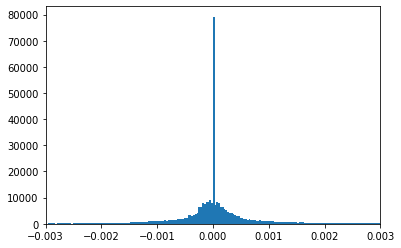

In [36]:
# Beta pred is a bit weird.  How bad are the errors
plt.hist((old_betas['beta_pred'] - new_betas['beta_pred'])/old_betas['beta_pred'], bins=10000)
#plt.plot(old_betas['beta_pred'])
plt.xlim([-.003, .003])
plt.show()

In [42]:
%%time
old_params = load_draw_files(old_params_path).set_index(['draw', 'params']).sort_index()
new_params = load_draw_files(new_params_path).set_index(['draw', 'params']).sort_index()

print('Equality test:', old_params.equals(new_params))

Equality test: False
CPU times: user 68.6 ms, sys: 121 ms, total: 190 ms
Wall time: 245 ms


In [48]:
# Let's see if some of this change is explicable
old_coef = load_draw_files(old_coef_path).drop(columns='Unnamed: 0').rename(columns={'testing_reference': 'testing'}).sort_values(['group_id', 'draw'])
new_coef = load_draw_files(new_coef_path).sort_values(['group_id', 'draw'])

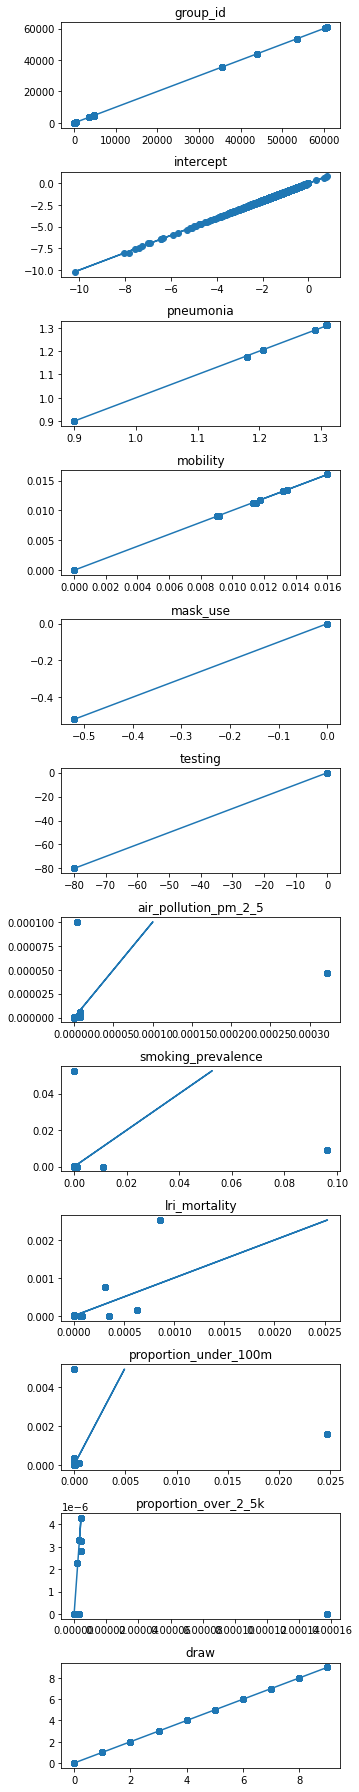

In [49]:
# Old covariate vs new covariate. Dots on the line is good
fig, ax = plt.subplots(nrows = len(new_coef.columns), figsize=(5, 25))
for i, col in enumerate(new_coef.columns):
    ax[i].plot(old_coef[col], old_coef[col])
    ax[i].scatter(new_coef[col], old_coef[col])
    ax[i].set_title(col)
fig.tight_layout()
plt.show()